# REINFORCE Policy Optimization with TensorFlow

In this notebook, we will look at policy optimization using TensorFlow. Let us quickly go through the derivation of what is policy Optimization and then we will apply this to CartPole environment - just like what we did in Chapter 6. 


### Derivation of Policy Gradient
In Policy Optimization, we will have a neural network which takes in state `s` as input and produces the `logits` for action probabilities. 

The policy is parameterized by $\theta$
$$\pi_\theta(a|s)$$

The agent follows the policy and generates the trajectory $\large \tau$ 

$$ s_1 \rightarrow a_1 \rightarrow s_2 \rightarrow a_2 \rightarrow .... \rightarrow s_{T-1} \rightarrow a_{T-1} \rightarrow s_T \rightarrow a_T$$ 

here $s_T$ is not necessarily the terminal state but some time horizon T upto which we are looking at the trajectory. 

The probability of trajectory $\large \tau$ depends on the transition probabilities $p(s_t+1 | s_t, a_t)$ and the policy $\pi_\theta(a_t|s_t)$. It is given by the expression:

$$p_\theta(\tau) = p_\theta(s_1, a_1, s_2, a_2, ..., s_T, a_T) = p(s_1)\prod_{t=1}^{T}\pi_\theta(a_t|s_t)p(s_{t+1}|s_t,a_t)$$

The expected return from following the policy $\pi$ is given by:

$$J(\theta) = {\large E}_{\tau \sim p_\theta(\tau)} \left[ \sum_{t} \gamma^t r(s_t, a_t) \right]$$

We want to find the $\theta$ which maximizes the expected reward/return $J(\theta)$. In other words, the optimal $\theta=\theta^*$ is given by expression

$$\theta^* = arg \underset{\theta}{max}{\large E}_{\tau \sim p_\theta(\tau)} \left[ \sum_{t} \gamma^t r(s_t, a_t) \right] $$

Moving on, let us try to find the optimal $\theta$. To keep the notations easier to understand, we will replace $\sum_{t} \gamma^t r(s_t, a_t)$ as $r(\tau)$:

$$J(\theta) = {\large E}_{\tau \sim p_\theta(\tau)} \left[ r(\tau) \right] = \int p_\theta(\tau)r(\tau) d\tau$$

We take the gradient/derivative of above expression with respect to $\theta$:

$$\nabla_{\theta} J(\theta) =  \nabla_{\theta} \int p_\theta(\tau)r(\tau) d\tau $$

By linearity we can move the gradient inside the integral:

$$\nabla_{\theta} J(\theta) =  \int \nabla_{\theta} p_\theta(\tau)r(\tau) d\tau $$

Using log derivative trick, we know that $\nabla_x f(x) = f(x) \nabla_x \log{f(x)}$. Using this we can write above expression as:

$$\nabla_{\theta} J(\theta) =  \int p_\theta(\tau) \left[ \nabla_{\theta}\log{p_\theta(\tau)} r(\tau) \right] d\tau $$

We can now write the integral back as expectation, which gives us the expression:

$$\nabla_{\theta} J(\theta) =  {\large E}_{\tau \sim p_\theta(\tau)} \left[ \nabla_{\theta}\log{p_\theta(\tau)} r(\tau) \right] $$

Let us now expand the term $\nabla_{\theta}\log{p_\theta(\tau)}$ by writing out the full expression of $p_\theta(\tau)$. 

$$ \nabla_{\theta}\log{p_\theta(\tau)}  = \nabla_{\theta} \log{ \left[ p(s_1) \prod_{t=1}^{T}\pi_\theta(a_t|s_t)p(s_{t+1}|s_t,a_t)\right]}$$

We know that log of product of terms can be written as sum of log of terms i.e. 

$$\log{\prod_i f_i(x)} = \sum_i log{f_i(x)}$$ 

Using the above substitution, we get:

$$ \nabla_{\theta}\log{p_\theta(\tau)}  = \nabla_{\theta} \left[ log{p(s_1)} +  \sum_{t=1}^{T} \left\{ \log{ \pi_\theta(a_t|s_t)} + \log{p(s_{t+1}|s_t,a_t)} \right\} \right]$$

The only term dependent on $\theta$ is $\pi_\theta(a_t|s_t)$. The other two terms $log{p(s_1)}$ and $\log{p(s_{t+1}|s_t,a_t)}$ do not depend on $\theta$. Accordingly, we can simplify the above expression as:

$$ \nabla_{\theta}\log{p_\theta(\tau)}  = \sum_{t=1}^{T} \nabla_{\theta} \log{ \pi_\theta(a_t|s_t)} $$


Substituting the above term into the expression for $\nabla_{\theta} J(\theta)$, as well as expanding $r(\tau)$ we get:

$$\nabla_{\theta} J(\theta) =  {\large E}_{\tau \sim p_\theta(\tau)} \left[ \left( \sum_{t=1}^{T} \nabla_{\theta} \log{ \pi_\theta(a_t|s_t)} \right) \left( \sum_{t=1}^{T} \gamma^t r(s_t, a_t) \right) \right] $$

We can now replace the outer expectation with an estimate over multiple trajectories to get the following expression for the gradient of policy objective:

$$\nabla_{\theta} J(\theta) =  \frac{1}{N} \sum_{i=1}^{N} \left[ \left( \sum_{t=1}^{T} \nabla_{\theta} \log{ \pi_\theta(a_t^i|s_t^i)} \right) \left( \sum_{t=1}^{T} \gamma^t r(s_t^i, a_t^i) \right) \right] $$

where i denotes the $i^{th}$ trajectory. 

To improve the policy, we now take a +ve step in $\theta$ in the direction of $\nabla_{\theta} J(\theta)$:

$$\theta = \theta + \alpha \nabla_{\theta} J(\theta)$$

To summarize, we design a model which takes state $s$ as input and produces the policy distribution $\pi_\theta(a|s)$ as the output of the model. We use a policy to generate returns and then change the model parameter $\theta$ using the expression: $\theta = \theta + \alpha \nabla_{\theta} J(\theta)$


### Rewards to Go Trick


we drop the reward terms that came before time t as at time t, the action we take can only impact the reward which comes at time t and later. This leads to changing the 2nd inner sum going from t’=t to T instead of earlier sum over t’ going from t’=1 to T. i.e. the start index is now t’=t and not t=1. The revised expression is given below:


$$\nabla_{\theta} J(\theta) =  \frac{1}{N} \sum_{i=1}^{N} \left[  \sum_{t=1}^{T}  \left( \nabla_{\theta} \log{ \pi_\theta(a_t^i|s_t^i)} \sum_{t'=t}^{T} \gamma^{t'-t} r(s_{t'}^i, a_{t'}^i) \right) \right] $$


### Implementing Loss and Gradient Step in PyTorch/TensorFlow

We will implement a pseudo loss function, whose derivative will give us $\nabla_{\theta} J(\theta)$. Also as PyTorch/TensorFlow carryout a gradient Step, we will convert maximization to minimization by changing the sign of this objective function

$$L_{CrossEntropy}(\theta) = - J(\theta) = - \frac{1}{N} \sum_{i=1}^{N} \left[ \sum_{t=1}^{T} \left(  \log{ \pi_\theta(a_t^i|s_t^i)} \sum_{t'=t}^{T} \gamma^{t'-t} r(s_{t'}^i, a_{t'}^i) \right) \right] $$

To summarize, we will pass the state `s` through the network to get $\log{ \pi_\theta(a_t^i|s_t^i)}$. We will calculate the cross_entropy loss for the actions actually seen in the trajectory. We will then calculate the weighted mean of these individual loss terms in the trajectory with weights being the rewards-to-go $\sum_{t'=t}^{T} \gamma^{t'-t} r(s_{t'}^i, a_{t'}^i)$

This will be followed by a gradient step in -ve direction of weighted NLL (negative log loss) i.e. in positive direction of the gradient of $J(\theta)= - L_{CrossEntropy}(\theta)$ 

We also add a regularization term known as Entropy. Entropy of a distribution is defined as:

$$H(X) = \sum_x -p(x).log(p(x))$$

To keep enough exploration, we will want the probability to have a spread out distribution and not let the probability distribution to collapse to a single value or a small region too soon. BIgger the spread of a distribution, higher the entropy H(x) of a distribution. Accordingly, the term fed into PyTorch/TensorFlow minimizer is:


$$Loss(\theta) = - J(\theta) - H(\pi_\theta(a_t^i|s_t^i)) = - \frac{1}{N} \sum_{i=1}^{N} \left[ \sum_{t=1}^{T} \left(  \log{ \pi_\theta(a_t^i|s_t^i)} \sum_{t'=t}^{T} \gamma^{t'-t} r(s_{t'}^i, a_{t'}^i) \right) - \beta \sum_{a_i} \pi_\theta(a_t^i|s_t^i).\log{ \pi_\theta(a_t^i|s_t^i)} \right] $$



In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model
import gym
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve, gaussian

import os
import io
import base64
import time
import glob
from IPython.display import HTML

%matplotlib inline

### Environment - CartPole 

We can use the setup here to run on any environment which has state as a single vector and actions are discrete. We will build it on Cart Pole and they try to run this on many other environments like Atari games and others.

In [2]:
def make_env(env_name, seed=None):
    # remove time limit wrapper from environment
    env = gym.make(env_name).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

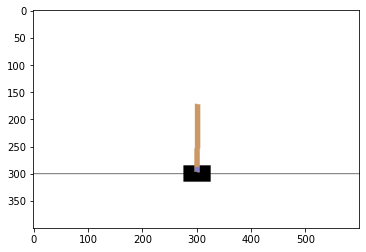

In [3]:
env_name = 'CartPole-v1'

env = make_env(env_name)
env.reset()
plt.imshow(env.render("rgb_array"))
state_shape, n_actions = env.observation_space.shape, env.action_space.n
state_dim = state_shape[0]
env.close()

### Build Policy Network

We will build a simple network that takes in state and produces logits for the action probabilities. We will keep network simple. he observation space and action space is as given below for CartPole

    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        

The model will be a simple one with 1 hidden layer with Relu activation and final layer being logits with dimension equal to number of actions.

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(state_dim,)),
    tf.keras.layers.Dense(n_actions)
])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               640       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 898
Trainable params: 898
Non-trainable params: 0
_________________________________________________________________


### Predict Action Probabilities

We will use this function to generate the trajectory. 

In [6]:
def predict_probs(states):
    """
    params: states: [batch, state_dim]
    returns: probs: [batch, n_actions]
    """
    logits = model(states)
    probs = tf.nn.softmax(logits, axis=-1).numpy()
    return probs

### Play game and generate Trajectory

In [7]:
def generate_trajectory(env, n_steps=1000):
    """
    Play a session and generate a trajectory
    returns: arrays of states, actions, rewards
    """
    states, actions, rewards = [], [], []
    
    # initialize the environment
    s = env.reset()
    
    # generate n_steps of trajectory:
    for t in range(n_steps):
        action_probs = predict_probs(np.array([s]))[0]
        # sample action based on action_probs
        a = np.random.choice(n_actions, p=action_probs)
        next_state, r, done, _ = env.step(a)
        
        # update arrays
        states.append(s)
        actions.append(a)
        rewards.append(r)
        
        s = next_state
        if done:
            break
    return states, actions, rewards

### Calculate Rewards to Go

 $G(s_t) = \sum_{t'=t}^{T} \gamma^{t-t'} r(s_{t'}^i, a_{t'}^i)$

In [8]:
def get_rewards_to_go(rewards, gamma=0.99):
    T = len(rewards) # total number of individual rewards
    # empty array to return the rewards to go
    rewards_to_go = [0] * T
    rewards_to_go[T - 1] = rewards[T - 1]
    
    for i in range(T-2, -1, -1): # go from T-2 to 0
        rewards_to_go[i] = gamma * rewards_to_go[i + 1] + rewards[i]
        
    return rewards_to_go

### Train on one trajectory

We will calculate the loss and take a gradient step. We will use Adam Optimizer

We are taking only one trajectory. so N=1. We will however, average it over the number of actions to get the average loss. So the function we will actually implement is as given below:

$$Loss(\theta) = - J(\theta) - H(\pi_\theta(a_t|s_t)) = - \frac{1}{T}  \sum_{t=1}^{T} \left( \log{ \pi_\theta(a_t|s_t)} G(s_t) - \beta \sum_{a_i} \pi_\theta(a_t|s_t).\log{ \pi_\theta(a_t|s_t)} \right) $$


In [9]:
# init Optimizer
optimizer = tf.keras.optimizers.Adam()

def train_one_episode(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    # get rewards to go
    rewards_to_go = get_rewards_to_go(rewards, gamma)
    
    # convert to numpy arrays
    states = np.array(states)
    actions = np.array(actions)
    rewards_to_go = np.array(rewards_to_go)
    
    with tf.GradientTape() as tape:
        # get actioin probabilities from states
        logits = model(states)
        probs = tf.nn.softmax(logits, -1)
        log_probs = tf.nn.log_softmax(logits, -1)
        
        row_indices = tf.range(len(actions))
        indices = tf.transpose([row_indices, actions])
        log_probs_for_actions = tf.gather_nd(log_probs, indices)
        
        # Compute loss to be minized
        J = tf.reduce_mean(log_probs_for_actions * rewards_to_go)
        H = -tf.reduce_mean(tf.reduce_sum(probs * log_probs, -1))
        
        loss = -(J + entropy_coef * H)
    
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return np.sum(rewards) # to show progress on training

### Train the agent

In [10]:
total_rewards = []
for i in range(10000):
    states, actions, rewards = generate_trajectory(env)
    reward = train_one_episode(states, actions, rewards)
    total_rewards.append(reward)
    if i != 0 and i % 100 == 0:
        mean_reward = np.mean(total_rewards[-100: -1])
        print("mean reward:%.3f" % (mean_reward))
        if mean_reward > 300:
            break
env.close()

mean reward:26.162
mean reward:61.051
mean reward:73.333
mean reward:115.818
mean reward:154.960
mean reward:146.343
mean reward:344.111


**Let us record a video of trained agent**

In [11]:
def generate_animation(env, save_dir):
    try:
        env = gym.wrappers.Monitor(
            env, save_dir, video_callable=lambda id: True, force=True, mode='evaluation')
    except gym.error.Error as e:
        print(e)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    generate_trajectory(env)



def display_animation(filepath):
    video = io.open(filepath, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii')))

In [13]:
# Animate learned policy
save_dir='./videos/tensorflow/reinforce/'
env = make_env(env_name)
generate_animation(env, save_dir=save_dir)
[filepath] = glob.glob(os.path.join(save_dir, '*.mp4'))
display_animation(filepath)